In [1]:
import os
working_path = "/home/mgeraldo/DATASCI210/team_repo/exercise_data"
print(f"Original working directory: {os.getcwd()}")
os.chdir(working_path)
print(f"Current working directory: {os.getcwd()}")
checkpoints_path = "/home/mgeraldo/DATASCI210/team_repo/exercise_data/enrichment/"

Original working directory: /home/mgeraldo/DATASCI210/team_repo/exercise_data
Current working directory: /home/mgeraldo/DATASCI210/team_repo/exercise_data


In [2]:
import json
from typing import List, Dict
from collections import defaultdict

def categorize_exercises(exercises: List[Dict]) -> Dict[str, List[Dict]]:
    """
    Group exercises by movement pattern and body region
    This allows us to create better templates and batch similar exercises
    """
    categories = defaultdict(list)
    
    for exercise in exercises:
        # Extract key attributes
        primary_muscle = exercise.get('primaryMuscles', ['unknown'])[0]
        mechanic = exercise.get('mechanic', 'unknown')
        equipment = exercise.get('equipment', 'unknown')
        
        # Create category key
        category = f"{primary_muscle}_{mechanic}_{equipment}"
        categories[category].append(exercise)
    
    return dict(categories)

def assess_risk_level(exercise: Dict) -> str:
    """
    Assign risk level based on exercise characteristics
    """
    risk_indicators = {
        'high': [
            'deadlift', 'squat', 'clean', 'snatch', 'overhead',
            'spinal', 'inversion', 'plyometric', 'jump'
        ],
        'moderate': [
            'lunge', 'row', 'press', 'curl', 'extension',
            'rotation', 'twist'
        ],
        'low': [
            'walk', 'stretch', 'plank', 'hold', 'isometric'
        ]
    }
    
    name_lower = exercise['name'].lower()
    
    for risk, keywords in risk_indicators.items():
        if any(keyword in name_lower for keyword in keywords):
            return risk
    
    return 'moderate'  # Default

# Usage
with open('exercises.json', 'r') as f:
    exercises = json.load(f)

categorized = categorize_exercises(exercises)
print(f"Created {len(categorized)} categories from {len(exercises)} exercises")

Created 223 categories from 873 exercises


In [3]:
categorized.keys()

dict_keys(['abdominals_compound_body only', 'hamstrings_None_body only', 'abdominals_isolation_machine', 'abdominals_compound_other', 'adductors_isolation_foam roll', 'adductors_None_None', 'abdominals_isolation_kettlebells', 'quadriceps_None_body only', 'biceps_isolation_dumbbell', 'abdominals_isolation_body only', 'quadriceps_compound_None', 'shoulders_compound_cable', 'shoulders_isolation_dumbbell', 'chest_compound_kettlebells', 'hamstrings_compound_kettlebells', 'shoulders_compound_kettlebells', 'middle back_isolation_kettlebells', 'middle back_compound_kettlebells', 'calves_isolation_None', 'glutes_None_None', 'calves_None_other', 'shoulders_compound_barbell', 'shoulders_isolation_None', 'shoulders_compound_dumbbell', 'chest_compound_dumbbell', 'lower back_compound_other', 'shoulders_compound_bands', 'quadriceps_compound_other', 'shoulders_compound_medicine ball', 'calves_compound_other', 'hamstrings_isolation_exercise ball', 'lats_compound_other', 'hamstrings_compound_bands', 'ad

In [4]:
def create_enrichment_prompt(exercise: Dict, similar_examples: List[Dict] = None) -> str:
    """
    Generate comprehensive prompt for exercise enrichment
    """
    
    prompt = f"""You are a certified exercise physiologist and physical therapist with 15+ years of clinical experience. 
    Your task is to provide comprehensive safety and modification information for exercises.

EXERCISE TO ANALYZE:
Name: {exercise['name']}
Primary Muscles: {', '.join(exercise.get('primaryMuscles', []))}
Equipment: {exercise.get('equipment', 'N/A')}
Mechanic: {exercise.get('mechanic', 'N/A')}
Level: {exercise.get('level', 'N/A')}
Instructions: {' '.join(exercise.get('instructions', []))}

YOUR TASK:
Provide a complete safety analysis in JSON format with the following structure:

{{
  "secondaryMuscles": [],  // List of secondary/stabilizer muscles involved
  "contraindications": [],  // Medical conditions/injuries that should avoid this exercise
  "contraindicationDetails": {{}},  // Detailed explanation for each contraindication
  "modifications": {{}},  // Easier/harder/injury-friendly variations
  "safetyNotes": [],  // Critical safety reminders
  "formCues": [],  // Key coaching cues for proper form
  "commonMistakes": [],  // Frequent errors to avoid
  "recommendedSets": {{}},  // Sets by experience level
  "recommendedReps": {{}},  // Reps by training goal
  "restPeriodSeconds": {{}},  // Rest periods by experience
  "caloriesPerMinute": {{}},  // Caloric expenditure estimates
  "timeEstimate": {{}}  // Time per set including rest
}}

CONTRAINDICATIONS CATEGORIES TO CONSIDER:
- Spinal injuries (herniated disc, stenosis, spondylolisthesis, sciatica)
- Joint issues (arthritis, impingement, tendinitis, bursitis)
- Cardiovascular conditions (hypertension, heart disease)
- Pregnancy and postpartum
- Surgical recovery (specific to body region)
- Chronic conditions (osteoporosis, diabetes complications)
- Acute injuries (sprains, strains, recent trauma)
- Neurological conditions (neuropathy, balance disorders)

SEVERITY LEVELS:
- "high": Exercise should be completely avoided
- "moderate": Exercise requires significant modification
- "low": Exercise can be done with minor adjustments

MODIFICATION TYPES TO INCLUDE:
- easier: Lower-difficulty variation
- harder: Higher-difficulty progression
- injury_friendly: Specific modifications for common injuries (back pain, knee pain, shoulder pain, etc.)

GUIDELINES:
1. Be specific and evidence-based
2. Consider biomechanics and load distribution
3. Include contraindications even if rare but serious
4. Provide practical alternatives when needed
5. Use medical terminology correctly
6. Focus on safety without being overly cautious
7. Consider the exercise's force vector and joint stress patterns

"""

    # Add similar examples if available for context
    if similar_examples:
        prompt += "\n\nEXAMPLES OF SIMILAR EXERCISES FOR REFERENCE:\n"
        for example in similar_examples[:2]:
            prompt += f"\nExample: {example['name']}\n"
            prompt += f"Contraindications: {', '.join(example.get('contraindications', [])[:5])}\n"
    
    prompt += "\n\nProvide the complete JSON response now:"
    
    return prompt

In [5]:
# Batch Processing Implementation

from openai import OpenAI
import time
from typing import Optional
import logging

class ExerciseEnricher:
    """
    Handles LLM-based enrichment of exercise database
    """
    
    def __init__(self, api_key: str, model: str = "gpt-4o"):
        self.client = OpenAI(api_key=api_key)
        self.model = model
        self.logger = logging.getLogger(__name__)
        
        # Track costs and usage
        self.total_tokens = 0
        self.total_cost = 0.0
        self.pricing = {
            "gpt-4o": {"input": 0.0025, "output": 0.01},  # per 1K tokens
            "gpt-4o-mini": {"input": 0.00015, "output": 0.0006}
        }
    
    def enrich_exercise(
        self, 
        exercise: Dict, 
        similar_examples: Optional[List[Dict]] = None,
        max_retries: int = 3
    ) -> Dict:
        """
        Enrich a single exercise with LLM-generated data
        """
        prompt = create_enrichment_prompt(exercise, similar_examples)
        
        for attempt in range(max_retries):
            try:
                response = self.client.chat.completions.create(
                    model=self.model,
                    messages=[
                        {
                            "role": "system",
                            "content": "You are an expert exercise physiologist and physical therapist. Provide accurate, evidence-based safety information in valid JSON format."
                        },
                        {
                            "role": "user",
                            "content": prompt
                        }
                    ],
                    temperature=0.3,  # Lower temperature for consistency
                    response_format={"type": "json_object"}
                )
                
                # Extract and parse response
                enriched_data = json.loads(response.choices[0].message.content)
                
                # Track usage
                self.total_tokens += response.usage.total_tokens
                input_cost = response.usage.prompt_tokens / 1000 * self.pricing[self.model]["input"]
                output_cost = response.usage.completion_tokens / 1000 * self.pricing[self.model]["output"]
                self.total_cost += input_cost + output_cost
                
                # Merge with original exercise
                enriched_exercise = {**exercise, **enriched_data}
                
                return enriched_exercise
                
            except Exception as e:
                self.logger.warning(f"Attempt {attempt + 1} failed for {exercise['name']}: {str(e)}")
                if attempt == max_retries - 1:
                    self.logger.error(f"Failed to enrich {exercise['name']} after {max_retries} attempts")
                    return exercise  # Return original if all retries fail
                time.sleep(2 ** attempt)  # Exponential backoff
    
    def enrich_batch(
        self, 
        exercises: List[Dict],
        batch_size: int = 10,
        save_interval: int = 50
    ) -> List[Dict]:
        """
        Enrich multiple exercises with progress tracking and checkpointing
        """
        enriched_exercises = []
        total = len(exercises)
        
        for i in range(0, total, batch_size):
            batch = exercises[i:i + batch_size]
            
            self.logger.info(f"Processing batch {i//batch_size + 1}/{(total + batch_size - 1)//batch_size}")
            
            for j, exercise in enumerate(batch):
                try:
                    # Find similar exercises for context (from already processed)
                    similar = self._find_similar_exercises(exercise, enriched_exercises)
                    
                    # Enrich
                    enriched = self.enrich_exercise(exercise, similar)
                    enriched_exercises.append(enriched)
                    
                    # Progress
                    current = i + j + 1
                    self.logger.info(f"✓ {current}/{total} - {exercise['name']}")
                    
                    # Rate limiting (respect API limits)
                    time.sleep(0.5)
                    
                except Exception as e:
                    self.logger.error(f"Error processing {exercise['name']}: {str(e)}")
                    enriched_exercises.append(exercise)  # Keep original
            
            # Checkpoint save
            if (i + batch_size) % save_interval == 0:
                self._save_checkpoint(enriched_exercises, f"checkpoint_{i + batch_size}.json")
        
        return enriched_exercises
    
    def _find_similar_exercises(
        self, 
        exercise: Dict, 
        existing: List[Dict],
        max_similar: int = 2
    ) -> List[Dict]:
        """
        Find similar exercises from already-enriched ones to provide as examples
        """
        if not existing:
            return []
        
        # Simple similarity: same primary muscle + same equipment
        similar = []
        target_muscle = exercise.get('primaryMuscles', [''])[0]
        target_equipment = exercise.get('equipment', '')
        
        for ex in existing:
            if len(similar) >= max_similar:
                break
            
            if (target_muscle in ex.get('primaryMuscles', []) and 
                ex.get('equipment') == target_equipment and
                'contraindications' in ex):  # Must be already enriched
                similar.append(ex)
        
        return similar
    
    def _save_checkpoint(self, data: List[Dict], filename: str):
        """Save progress checkpoint"""
        with open(checkpoints_path + filename, 'w') as f:
            json.dump(data, f, indent=2)
        self.logger.info(f"💾 Checkpoint saved: {filename}")
    
    def print_summary(self):
        """Print cost and usage summary"""
        print("\n" + "="*50)
        print("ENRICHMENT SUMMARY")
        print("="*50)
        print(f"Total Tokens Used: {self.total_tokens:,}")
        print(f"Total Cost: ${self.total_cost:.2f}")
        print(f"Model: {self.model}")
        print("="*50 + "\n")

In [6]:
# Automated validation checks

class EnrichmentValidator:
    """
    Validates enriched exercise data for completeness and quality
    """
    
    REQUIRED_FIELDS = [
        'secondaryMuscles',
        'contraindications',
        'modifications',
        'safetyNotes',
        'formCues'
    ]
    
    COMMON_CONTRAINDICATIONS = [
        'lower_back_pain', 'herniated_disc', 'sciatica',
        'knee_pain', 'shoulder_pain', 'neck_pain',
        'pregnancy', 'osteoporosis', 'hypertension'
    ]
    
    def __init__(self):
        self.issues = []
    
    def validate_exercise(self, exercise: Dict) -> Dict:
        """
        Run all validation checks on an enriched exercise
        """
        results = {
            'exercise_name': exercise['name'],
            'is_valid': True,
            'errors': [],
            'warnings': [],
            'quality_score': 0
        }
        
        # Check 1: Required fields present
        for field in self.REQUIRED_FIELDS:
            if field not in exercise:
                results['errors'].append(f"Missing required field: {field}")
                results['is_valid'] = False
            elif not exercise[field]:  # Empty
                results['warnings'].append(f"Empty field: {field}")
        
        # Check 2: Contraindications completeness
        if 'contraindications' in exercise:
            contraindications = exercise['contraindications']
            
            if len(contraindications) < 3:
                results['warnings'].append(
                    f"Only {len(contraindications)} contraindications listed. Consider reviewing."
                )
            
            # Check if high-risk exercises have appropriate contraindications
            name_lower = exercise['name'].lower()
            high_risk_keywords = ['deadlift', 'squat', 'overhead', 'spinal']
            
            if any(keyword in name_lower for keyword in high_risk_keywords):
                if not any('back' in c for c in contraindications):
                    results['warnings'].append(
                        "High-risk exercise missing back-related contraindications"
                    )
        
        # Check 3: Modification structure
        if 'modifications' in exercise:
            mods = exercise['modifications']
            required_mod_types = ['easier', 'injury_friendly']
            
            for mod_type in required_mod_types:
                if mod_type not in mods:
                    results['warnings'].append(f"Missing modification type: {mod_type}")
        
        # Check 4: Safety notes quality
        if 'safetyNotes' in exercise:
            if len(exercise['safetyNotes']) < 2:
                results['warnings'].append("Consider adding more safety notes")
        
        # Check 5: Contraindication details consistency
        if 'contraindications' in exercise and 'contraindicationDetails' in exercise:
            contraindications = set(exercise['contraindications'])
            detailed = set(exercise['contraindicationDetails'].keys())
            
            # High-severity ones should have details
            if len(contraindications) > 0 and len(detailed) < len(contraindications) * 0.3:
                results['warnings'].append(
                    "Many contraindications lack detailed explanations"
                )
        
        # Calculate quality score (0-100)
        score = 100
        score -= len(results['errors']) * 20
        score -= len(results['warnings']) * 5
        results['quality_score'] = max(0, score)
        
        return results
    
    def validate_batch(self, exercises: List[Dict]) -> Dict:
        """
        Validate entire enriched database
        """
        validation_results = []
        
        for exercise in exercises:
            result = self.validate_exercise(exercise)
            validation_results.append(result)
        
        # Summary statistics
        total = len(validation_results)
        valid = sum(1 for r in validation_results if r['is_valid'])
        avg_score = sum(r['quality_score'] for r in validation_results) / total
        
        summary = {
            'total_exercises': total,
            'valid_exercises': valid,
            'invalid_exercises': total - valid,
            'average_quality_score': avg_score,
            'exercises_needing_review': [
                r for r in validation_results 
                if not r['is_valid'] or r['quality_score'] < 70
            ]
        }
        
        return {
            'summary': summary,
            'detailed_results': validation_results
        }
    
    def generate_report(self, validation_results: Dict, output_file: str = "validation_report.txt"):
        """
        Generate human-readable validation report
        """
        summary = validation_results['summary']
        
        report = f"""
╔════════════════════════════════════════════════════╗
║     EXERCISE DATABASE VALIDATION REPORT            ║
╚════════════════════════════════════════════════════╝

Total Exercises: {summary['total_exercises']}
Valid Exercises: {summary['valid_exercises']} ({summary['valid_exercises']/summary['total_exercises']*100:.1f}%)
Invalid Exercises: {summary['invalid_exercises']}
Average Quality Score: {summary['average_quality_score']:.1f}/100

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

EXERCISES REQUIRING REVIEW:
"""
        
        for ex in summary['exercises_needing_review']:
            report += f"\n📋 {ex['exercise_name']} (Score: {ex['quality_score']}/100)\n"
            
            if ex['errors']:
                report += "   ❌ Errors:\n"
                for error in ex['errors']:
                    report += f"      - {error}\n"
            
            if ex['warnings']:
                report += "   ⚠️  Warnings:\n"
                for warning in ex['warnings']:
                    report += f"      - {warning}\n"
        
        with open(output_file, 'w') as f:
            f.write(report)
        
        print(f"✅ Validation report saved to {output_file}")
        return report

In [7]:
# tools for review 
import random

def select_review_sample(
    exercises: List[Dict], 
    sample_size: int = 87,  # 10% of 873
    stratified: bool = True
) -> List[Dict]:
    """
    Select representative sample for expert review
    """
    
    if not stratified:
        return random.sample(exercises, sample_size)
    
    # Stratified sampling by risk level and muscle group
    categories = {
        'high_risk': [],
        'moderate_risk': [],
        'low_risk': []
    }
    
    for ex in exercises:
        risk = assess_risk_level(ex)
        categories[f'{risk}_risk'].append(ex)
    
    # Sample proportionally
    sample = []
    for category, exercises_in_category in categories.items():
        if exercises_in_category:
            n_to_sample = max(1, int(len(exercises_in_category) / len(exercises) * sample_size))
            sample.extend(random.sample(
                exercises_in_category, 
                min(n_to_sample, len(exercises_in_category))
            ))
    
    return sample[:sample_size]

def create_review_spreadsheet(sample: List[Dict], output_file: str = "expert_review.csv"):
    """
    Generate spreadsheet for expert review
    """
    import csv
    
    with open(output_file, 'w', newline='') as f:
        writer = csv.writer(f)
        
        # Header
        writer.writerow([
            'Exercise Name',
            'Primary Muscles',
            'Risk Level',
            'Contraindications Count',
            'Quality Score',
            'Expert Approval (Y/N)',
            'Corrections Needed',
            'Notes'
        ])
        
        # Data rows
        for ex in sample:
            writer.writerow([
                ex['name'],
                ', '.join(ex.get('primaryMuscles', [])),
                assess_risk_level(ex),
                len(ex.get('contraindications', [])),
                'N/A',  # To be filled by validator
                '',  # Expert fills
                '',  # Expert fills
                ''   # Expert fills
            ])
    
    print(f"✅ Review spreadsheet created: {output_file}")
    

In [8]:
# Pipeline execution 

import logging
import sys
from datetime import datetime

def setup_logging():
    """Configure logging"""
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(f'enrichment_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log'),
            logging.StreamHandler(sys.stdout)
        ]
    )

def main():
    """
    Main pipeline execution
    """
    setup_logging()
    logger = logging.getLogger(__name__)
    
    logger.info("="*50)
    logger.info("EXERCISE DATABASE ENRICHMENT PIPELINE")
    logger.info("="*50)
    
    # Reading credentials 
    with open("open_ai_key.txt","r") as key_file:
        open_ai_key = key_file.read().rstrip("\n")
    
    # Step 1: Load original database
    logger.info("\n📂 Step 1: Loading exercise database...")
    with open('exercises.json', 'r') as f:
        exercises = json.load(f)
    logger.info(f"✓ Loaded {len(exercises)} exercises")
    
    # Step 2: Initialize enricher
    logger.info("\n🤖 Step 2: Initializing LLM enricher...")
    enricher = ExerciseEnricher(
        api_key=open_ai_key,
        model="gpt-4o"  # or "gpt-4o-mini" for lower cost
    )
    
    # Step 3: Categorize exercises
    logger.info("\n📊 Step 3: Categorizing exercises...")
    categorized = categorize_exercises(exercises)
    logger.info(f"✓ Created {len(categorized)} categories")
    
    # Step 4: Enrich exercises
    logger.info("\n🔄 Step 4: Enriching exercises with LLM...")
    logger.info(f"   Model: {enricher.model}")
    logger.info(f"   Estimated time: {len(exercises) * 1.5 / 60:.1f} minutes")
    
    enriched_exercises = enricher.enrich_batch(
        exercises,
        batch_size=10,
        save_interval=50
    )
    
    enricher.print_summary()
    
    # Step 5: Validate
    logger.info("\n✅ Step 5: Validating enriched data...")
    validator = EnrichmentValidator()
    validation_results = validator.validate_batch(enriched_exercises)
    
    logger.info(f"✓ Valid: {validation_results['summary']['valid_exercises']}/{validation_results['summary']['total_exercises']}")
    logger.info(f"✓ Avg Quality Score: {validation_results['summary']['average_quality_score']:.1f}/100")
    
    # Generate validation report
    validator.generate_report(validation_results)
    
    # Step 6: Save enriched database
    logger.info("\n💾 Step 6: Saving enriched database...")
    output_file = f'exercise_enriched_{datetime.now().strftime("%Y%m%d")}.json'
    with open(output_file, 'w') as f:
        json.dump(enriched_exercises, f, indent=2)
    logger.info(f"✓ Saved to {output_file}")
    
    # Step 7: Prepare expert review sample
    logger.info("\n👨‍⚕️ Step 7: Preparing expert review sample...")
    review_sample = select_review_sample(enriched_exercises, sample_size=87)
    create_review_spreadsheet(review_sample)
    
    # Save sample for review
    with open('review_sample.json', 'w') as f:
        json.dump(review_sample, f, indent=2)
    
    logger.info("\n" + "="*50)
    logger.info("✅ PIPELINE COMPLETED SUCCESSFULLY")
    logger.info("="*50)
    logger.info(f"\nNext steps:")
    logger.info(f"1. Review validation report: validation_report.txt")
    logger.info(f"2. Send expert_review.csv to domain experts")
    logger.info(f"3. Apply corrections from expert review")
    logger.info(f"4. Use {output_file} in production")
    
if __name__ == "__main__":
    main()

2025-10-02 15:26:29,195 - INFO - ==================================================
2025-10-02 15:26:29,197 - INFO - EXERCISE DATABASE ENRICHMENT PIPELINE
2025-10-02 15:26:29,198 - INFO - ==================================================
2025-10-02 15:26:29,200 - INFO - 
📂 Step 1: Loading exercise database...
2025-10-02 15:26:29,214 - INFO - ✓ Loaded 873 exercises
2025-10-02 15:26:29,215 - INFO - 
🤖 Step 2: Initializing LLM enricher...
2025-10-02 15:26:29,279 - INFO - 
📊 Step 3: Categorizing exercises...
2025-10-02 15:26:29,280 - INFO - ✓ Created 223 categories
2025-10-02 15:26:29,281 - INFO - 
🔄 Step 4: Enriching exercises with LLM...
2025-10-02 15:26:29,282 - INFO -    Model: gpt-4o
2025-10-02 15:26:29,283 - INFO -    Estimated time: 21.8 minutes
2025-10-02 15:26:29,284 - INFO - Processing batch 1/88
2025-10-02 15:26:36,260 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 15:26:36,292 - INFO - ✓ 1/873 - 3/4 Sit-Up
2025-10-02 15:26:4

2025-10-01 15:58:14,245 - INFO - 
📊 Step 3: Categorizing exercises...
2025-10-01 15:58:14,247 - INFO - ✓ Created 223 categories
2025-10-01 15:58:14,248 - INFO - 
🔄 Step 4: Enriching exercises with LLM...
2025-10-01 15:58:14,248 - INFO -    Model: gpt-4o
2025-10-01 15:58:14,249 - INFO -    Estimated time: 21.8 minutes
2025-10-01 15:58:14,252 - INFO - Processing batch 1/88
2025-10-01 15:58:14,352 - INFO - Retrying request to /chat/completions in 0.394106 seconds
2025-10-01 15:58:14,859 - INFO - Retrying request to /chat/completions in 0.945031 seconds
2025-10-01 15:58:15,927 - WARNING - Attempt 1 failed for 3/4 Sit-Up: Connection error.
2025-10-01 15:58:17,031 - INFO - Retrying request to /chat/completions in 0.482513 seconds
2025-10-01 15:58:17,613 - INFO - Retrying request to /chat/completions in 0.866054 seconds
2025-10-01 15:58:18,578 - WARNING - Attempt 2 failed for 3/4 Sit-Up: Connection error.
2025-10-01 15:58:20,681 - INFO - Retrying request to /chat/completions in 0.490693 secon

In [9]:
enr_file = json.load(open("exercise_enriched_20251002.json","r"))

In [50]:
contraindications_set = set()
lesions_set = set()
for exercise in enr_file:
    for cont_ind in exercise["contraindications"]:
        contraindications_set.add(cont_ind)
    try:
        for lesion in exercise["modifications"]["injury_friendly"].keys():
            lesion = lesion.lower().replace("_"," ")
            if lesion == "handpain":
                lesion = "hand pain"
            elif lesion == "shoulderpain":
                lesion = "shoulder pain"
            lesions_set.add(lesion)
    except: 
        continue

In [128]:
len(contraindications_set)

247

In [127]:
lesions_set

{'achilles tendinitis',
 'ankle instability',
 'ankle pain',
 'arthritis',
 'back pain',
 'balance disorders',
 'balance issues',
 'carpal tunnel',
 'cervical spine issues',
 'chest pain',
 'elbow pain',
 'elbow tendinitis',
 'groin strain',
 'hand pain',
 'hip pain',
 'knee pain',
 'lower back pain',
 'neck pain',
 'plantar fasciitis',
 'shoulder pain',
 'wrist pain'}

In [53]:
len(lesions_set)

21

In [208]:
# Use ChatGPT to reclassify the contraindications 
with open("open_ai_key.txt","r") as key_file:
        open_ai_key = key_file.read().rstrip("\n")

client = OpenAI(api_key = open_ai_key)

prompt = f"Analyze this list of exercise contraindications and classify them into the following categories \
['back and spinal issues', 'chest and shoulder issues', 'arm and hand issues', 'knee and foot issues', 'Pregnancy','Cardiovascular issues', \
'Hip or lumbar issues', 'chronical or neurological issues']. \
Your response must be a mapping in JSON format of all and each of the contraindications in the set below, and its assigned category. \
The labels in the JSON must fit the all the elements in the set shown below. \
Provide estrictly the json as output. Do NOT change the spelling of any contraindication. Map all contraindications.\n {contraindications_set}"

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are an expert on physical therapy."},
        {"role": "user", "content": prompt}
    ]
)

# Correct way to access content
print(response.choices[0].message.content)

2025-10-03 19:41:06,741 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
```json
{
    "acute shoulder bursitis": "chest and shoulder issues",
    "acute shoulder injury": "chest and shoulder issues",
    "tendinitis": "arm and hand issues",
    "rotator cuff injuries": "chest and shoulder issues",
    "severe cervical spine issues": "back and spinal issues",
    "severe arthritis in the shoulder joint": "chest and shoulder issues",
    "acute elbow injuries": "arm and hand issues",
    "spinal stenosis": "back and spinal issues",
    "lower back pain": "back and spinal issues",
    "recent back surgery": "back and spinal issues",
    "shoulder_injuries": "chest and shoulder issues",
    "recent hip surgery": "hip or lumbar issues",
    "Sciatica": "back and spinal issues",
    "knee pain": "knee and foot issues",
    "acute_knee_injuries": "knee and foot issues",
    "severe sciatica": "back and spinal issues",
    "cervical radiculopathy": "bac

In [288]:
#load the GPT answer into a dictionary, and find the set of categories used by GPT
import json

categories_dict = json.loads(response.choices[0].message.content.strip("```").strip("json"))
print("Number of contraindication categorized: ",len(cont_categories_dict))
cat_set = set()
for cont, cat in categories_dict.items():
    cat_set.add(cat)
print("Number of categories: ",len(cat_set))
print("Categories:\n", cat_set) 

Number of contraindication categorized:  246
Number of categories:  8
Categories:
 {'Pregnancy', 'chronical or neurological issues', 'hip or lumbar issues', 'chest and shoulder issues', 'back and spinal issues', 'arm and hand issues', 'knee and foot issues', 'Cardiovascular issues'}


In [289]:
#inserting the new category in the enriched data
print("Data type of the enriched file:",type(enr_file))
print("Data type of each element:",type(enr_file[10]))

error_l = list()
for exercise in enr_file:
    cont_l = set()
    for cont in exercise["contraindications"]:
        try:
            cont_l.add(categories_dict[cont])
        except Exception as error:
            print(error)
            error_l.append(cont)
            cont_l.add('Not Found')
    exercise["cont_cat"] = list(cont_l)

print('errors found:', len(error_l),'\n',error_l)


Data type of the enriched file: <class 'list'>
Data type of each element: <class 'dict'>
errors found: 0 
 []


In [290]:
# converting the dictionary of categories into Pandas for analysis
import pandas as pd
cont_df = pd.DataFrame.from_dict(categories_dict, orient = 'index').reset_index()
cont_df.columns = ['cont','cont_cat']
print("Contraindication by category\n",cont_df.cont_cat.value_counts())

Contraindication by category
 cont_cat
knee and foot issues                65
back and spinal issues              57
chest and shoulder issues           41
arm and hand issues                 34
chronical or neurological issues    20
Cardiovascular issues               14
hip or lumbar issues                10
Pregnancy                            6
Name: count, dtype: int64


In [264]:
# Manual review of an specific category
cont_df[cont_df.cont_cat=='back and spinal issues']

,cont,cont_cat
4,severe cervical spine issues,back and spinal issues
7,spinal stenosis,back and spinal issues
8,lower back pain,back and spinal issues
9,recent back surgery,back and spinal issues
12,Sciatica,back and spinal issues
15,severe sciatica,back and spinal issues
16,cervical radiculopathy,back and spinal issues
25,lumbar disc herniation,back and spinal issues
26,lumbar stenosis,back and spinal issues
30,recent abdominal or spinal surgery,back and spinal issues


In [291]:
# Manual Review of a specific line of enr_file
id_review = 2 
print(f"Exercise: {enr_file[id_review]['name']} \nContraindications: {enr_file[id_review]['contraindications']}\n\
Contraindication Categories: {enr_file[id_review]['cont_cat']}")

Exercise: Ab Crunch Machine 
Contraindications: ['spinal_injuries', 'abdominal_surgery', 'pregnancy', 'osteoporosis']
Contraindication Categories: ['Pregnancy', 'chronical or neurological issues', 'back and spinal issues']


In [266]:
# Extract a sample from enr_file for review
sample = select_review_sample(enr_file)
sample_df = pd.DataFrame.from_dict(sample)

In [267]:
# Manual review of the sample
pd.set_option('display.max_colwidth', None)
sample_df.loc[0:10,['name','force','equipment','primaryMuscles','contraindications','cont_cat']]

,name,force,equipment,primaryMuscles,contraindications,cont_cat
0,Jefferson Squats,push,barbell,[quadriceps],"[spinal_injuries, joint_issues, cardiovascular_conditions, pregnancy, surgical_recovery, chronic_conditions, acute_injuries, neurological_conditions]","[Pregnancy, chronical or neurological issues, back and spinal issues, knee and foot issues, Cardiovascular issues]"
1,Plie Dumbbell Squat,push,dumbbell,[quadriceps],"[knee osteoarthritis, patellar tendinitis, hip impingement, severe balance disorders, recent lower limb surgery, spinal stenosis, sciatica]","[knee and foot issues, chronical or neurological issues, hip or lumbar issues, back and spinal issues]"
2,Narrow Stance Squats,push,barbell,[quadriceps],"[spinal_injuries, joint_issues, cardiovascular_conditions, pregnancy, surgical_recovery, chronic_conditions, acute_injuries, neurological_conditions]","[Pregnancy, chronical or neurological issues, back and spinal issues, knee and foot issues, Cardiovascular issues]"
3,Hack Squat,push,machine,[quadriceps],"[knee osteoarthritis, patellar tendinitis, herniated disc, sciatica, recent knee surgery, severe cardiovascular conditions, balance disorders]","[knee and foot issues, chronical or neurological issues, back and spinal issues, Cardiovascular issues]"
4,Sled Overhead Backward Walk,pull,other,[shoulders],"[shoulder impingement, rotator cuff injuries, severe arthritis, recent shoulder surgery, balance disorders, hypertension]","[chronical or neurological issues, chest and shoulder issues, Cardiovascular issues]"
5,Cable Rope Overhead Triceps Extension,push,cable,[triceps],"[shoulder impingement, elbow tendinitis, acute lower back pain, cervical spine issues, osteoporosis]","[chronical or neurological issues, chest and shoulder issues, back and spinal issues, arm and hand issues]"
6,Seated Overhead Stretch,static,None,[abdominals],"[herniated disc, shoulder impingement, hypertension, osteoporosis, sciatica]","[chronical or neurological issues, chest and shoulder issues, back and spinal issues, Cardiovascular issues]"
7,Open Palm Kettlebell Clean,pull,kettlebells,[hamstrings],"[spinal_injuries, joint_issues, cardiovascular_conditions, pregnancy, surgical_recovery, acute_injuries, neurological_conditions]","[Pregnancy, chronical or neurological issues, back and spinal issues, knee and foot issues, Cardiovascular issues]"
8,Lying Machine Squat,push,machine,[quadriceps],"[herniated disc, knee osteoarthritis, severe cardiovascular conditions, recent lower limb surgery, balance disorders]","[knee and foot issues, chronical or neurological issues, back and spinal issues, Cardiovascular issues]"
9,One-Arm Kettlebell Snatch,pull,kettlebells,[shoulders],"[shoulder impingement, rotator cuff tendinitis, herniated cervical disc, uncontrolled hypertension, recent shoulder surgery, lower back pain, balance disorders]","[chronical or neurological issues, chest and shoulder issues, back and spinal issues, Cardiovascular issues]"


In [268]:
sample_df.loc[10:20,['name','instructions','equipment','primaryMuscles','contraindications','cont_cat']]

,name,instructions,equipment,primaryMuscles,contraindications,cont_cat
10,Car Deadlift,"[This event apparatus typically has neutral grip handles, however some have a straight bar that you can approach like a normal deadlift. The apparatus can be loaded with a vehicle or other heavy objects such as tractor tires or kegs., Center yourself between the handles if you are a strong squatter, or back a couple inches if you are a strong deadlifter. You feet should be about hip width apart. Bend at the hip to grip the handles. With your feet and your grip set, take a big breath and then lower your hips and flex the knees., Look forward with your head, keep your chest up and your back arched, and begin driving through the heels to move the weight upward. As the weight comes up, pull your shoulder blades together as you drive your hips forward., Lower the weight by bending at the hips and guiding it to the floor.]",other,[quadriceps],"[acute lower back pain, herniated disc, sciatica, knee osteoarthritis, recent lower limb surgery, balance disorders, uncontrolled hypertension]","[knee and foot issues, chronical or neurological issues, back and spinal issues, Cardiovascular issues]"
11,Snatch Pull,"[With a barbell on the floor close to the shins, take a wide snatch grip. Lower your hips with the weight focused on the heels, back straight, head facing forward, chest up, with your shoulders just in front of the bar. This will be your starting position., Begin the first pull by driving through the heels, extending your knees. Your back angle should stay the same, and your arms should remain straight. Move the weight with control as you continue to above the knees., Next comes the second pull, the main source of acceleration for the pull. As the bar approaches the mid-thigh position, begin extending through the hips. In a jumping motion, accelerate by extending the hips, knees, and ankles, using speed to move the bar upward., There should be no need to actively pull through the arms to accelerate the weight; at the end of the second pull, the body should be fully extended, leaning slightly back. Full extension should be violent and abrupt, and ensure that you do not prolong the extension for longer than necessary.]",barbell,[hamstrings],"[spinal_injuries, joint_issues, cardiovascular_conditions, pregnancy, surgical_recovery, chronic_conditions, acute_injuries, neurological_conditions]","[Pregnancy, chronical or neurological issues, back and spinal issues, knee and foot issues, Cardiovascular issues]"
12,Kettlebell Turkish Get-Up (Squat style),"[Lie on your back on the floor and press a kettlebell to the top position by extending the elbow. Bend the knee on the same side as the kettlebell., Keeping the kettlebell locked out at all times, pivot to the opposite side and use your non- working arm to assist you in driving forward to the lunge position., Using your free hand, push yourself to a seated position, then progressing to your feet. While looking up at the kettlebell, slowly stand up. Reverse the motion back to the starting position and repeat.]",kettlebells,[shoulders],"[shoulder impingement, rotator cuff tendinitis, herniated cervical or lumbar disc, uncontrolled hypertension, recent shoulder or spinal surgery, balance disorders, osteoporosis]","[chronical or neurological issues, chest and shoulder issues, back and spinal issues, Cardiovascular issues]"
13,Linear Depth Jump,"[You will need two boxes or benches spaced a few feet away from each other. Begin by standing on one box facing towards the other platform., To initiate the movement, gently drop down to the ground between your platforms, allowing the knees and hips to flex., Reverse the motion by exploding, extending through the hips, knees, and ankles to jump onto the other platform., Land softly, asborbing the impact through the legs.]",other,[quadriceps],"[knee osteoarthritis, acute lower back pain, balance disorders, recent lower limb surgery, herniated disc, ankle instability]",

In [269]:
sample_df.loc[20:30,['name','instructions','equipment','primaryMuscles','contraindications','cont_cat']]

,name,instructions,equipment,primaryMuscles,contraindications,cont_cat
20,Push-Ups With Feet On An Exercise Ball,"[Lie on the floor face down and place your hands about 36 inches apart from each other holding your torso up at arms length., Place your toes on top of an exercise ball. This will allow your body to be elevated., Lower yourself until your chest almost touches the floor as you inhale., Using your pectoral muscles, press your upper body back up to the starting position and squeeze your chest. Breathe out as you perform this step., After a second pause at the contracted position, repeat the movement for the prescribed amount of repetitions.]",exercise ball,[chest],"[shoulder impingement, rotator cuff tear, wrist tendinitis, carpal tunnel syndrome, lower back pain, herniated disc, pregnancy (third trimester), balance disorders]","[Pregnancy, chronical or neurological issues, chest and shoulder issues, back and spinal issues, arm and hand issues]"
21,Arm Circles,"[Stand up and extend your arms straight out by the sides. The arms should be parallel to the floor and perpendicular (90-degree angle) to your torso. This will be your starting position., Slowly start to make circles of about 1 foot in diameter with each outstretched arm. Breathe normally as you perform the movement., Continue the circular motion of the outstretched arms for about ten seconds. Then reverse the movement, going the opposite direction.]",None,[shoulders],"[shoulder impingement, rotator cuff tear, severe arthritis, recent shoulder surgery]",[chest and shoulder issues]
22,Heavy Bag Thrust,"[Utilize a heavy bag for this exercise. Assume an upright stance next to the bag, with your feet staggered, fairly wide apart. Place your hand on the bag at about chest height. This will be your starting position., Begin by twisting at the waist, pushing the bag forward as hard as possible. Perform this move quickly, pushing the bag away from your body., Receive the bag as it swings back by reversing these steps.]",other,[chest],"[shoulder impingement, rotator cuff injuries, spinal injuries, osteoarthritis, cardiovascular conditions, pregnancy, acute wrist or elbow injuries]","[Pregnancy, chest and shoulder issues, back and spinal issues, arm and hand issues, knee and foot issues, Cardiovascular issues]"
23,Barbell Walking Lunge,"[Begin standing with your feet shoulder width apart and a barbell across your upper back., Step forward with one leg, flexing the knees to drop your hips. Descend until your rear knee nearly touches the ground. Your posture should remain upright, and your front knee should stay above the front foot., Drive through the heel of your lead foot and extend both knees to raise yourself back up., Step forward with your rear foot, repeating the lunge on the opposite leg.]",barbell,[quadriceps],"[spinal_injuries, joint_issues, cardiovascular_conditions, pregnancy, surgical_recovery, chronic_conditions, acute_injuries, neurological_conditions]","[Pregnancy, chronical or neurological issues, back and spinal issues, knee and foot issues, Cardiovascular issues]"
24,Bench Sprint,"[Stand on the ground with one foot resting on a bench or box with your heel close to the edge., Push off with your foot on top of the bench, extending through the hip and knee., Land with the opposite foot on top of the box, returning your other foot back to the start position., Continue alternating from one foot to another to complete the set.]",other,[quadriceps],"[knee osteoarthritis, acute lower back pain, balance disorders, recent lower limb surgery, hip bursitis]","[knee and foot issues, chronical or neurological issues, hip or lumbar issues, back and spinal issues]"
25,Hanging Leg Raise,"[Hang from a chin-up bar with both arms extended at arms length in top of you using either a wide grip or a medium grip. The legs should be straight down with the pelvis rolled slightly backwards. This will be your starting position., Raise your legs until the torso makes a 90-degree an

In [270]:
sample_df.columns

Index(['name', 'force', 'level', 'mechanic', 'equipment', 'primaryMuscles',
       'secondaryMuscles', 'instructions', 'category', 'images', 'id',
       'contraindications', 'contraindicationDetails', 'modifications',
       'safetyNotes', 'formCues', 'commonMistakes', 'recommendedSets',
       'recommendedReps', 'restPeriodSeconds', 'caloriesPerMinute',
       'timeEstimate', 'cont_cat'],
      dtype='object')

In [271]:
categories_dict['abdominal_surgery']

'back and spinal issues'

In [293]:
# Counting number of exercises contraindicated by category
cat_count = {cat:0 for cat in cat_set}
for exercise in enr_file:
    #print("name:", exercise['name'])
    #print("cat list:",exercise["cont_cat"])
    for cat in exercise["cont_cat"]:
        #print("cat:",cat)
        cat_count[cat]+=1
print("Number of exercises by contraindication category") 
display(cat_count)

Number of exercises by contraindication category


{'Pregnancy': 307,
 'chronical or neurological issues': 647,
 'hip or lumbar issues': 62,
 'chest and shoulder issues': 489,
 'back and spinal issues': 707,
 'arm and hand issues': 249,
 'knee and foot issues': 347,
 'Cardiovascular issues': 373}

## Manual review results

After the review of a random sample of 10% of the contranindications this is the resutl:
* No errors found
* Categories *"Pregnancy"* and *"Chronical or neurological issues"* are present in many cases.
* Back and spinal issues block most of the exercises


In [344]:
# Savind enriched data 
with open('exercise_enriched.json', 'w') as f:
    json.dump(enr_file,f,indent=2) 

## Correct errors in the structure of the JSON

In [345]:
import json
import copy
from datetime import datetime
from typing import Dict, List, Tuple

class ModificationsStructureFixer:
    """
    Fixes misplaced 'modifications' branches in exercise JSON
    """
    
    def __init__(self, json_data: List[Dict]):
        self.data = json_data
        self.report = {
            'total_exercises': len(json_data),
            'conflicts': [],  # Both top-level and nested modifications
            'migrations': [],  # Moved from nested to top-level
            'missing': [],  # No modifications at all
            'wrong_type': [],  # modifications is not a dict
            'empty': [],  # modifications = {}
            'cleaned_injury_friendly_cat': []  # Removed existing injury_friendly_cat
        }
    
    def create_backup(self, filename: str = None) -> str:
        """Create JSON backup before modifications"""
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"exercise_backup_{timestamp}.json"
        
        with open(filename, 'w') as f:
            json.dump(self.data, f, indent=2)
        
        print(f"✅ Backup created: {filename}")
        return filename
    
    def analyze_exercise(self, exercise: Dict, index: int) -> Dict:
        """
        Analyze a single exercise for structural issues
        Returns status dictionary
        """
        status = {
            'index': index,
            'name': exercise.get('name', f'Exercise_{index}'),
            'has_top_level_modifications': 'modifications' in exercise,
            'has_nested_modifications': False,
            'has_injury_friendly_cat': False,
            'modifications_type': None,
            'modifications_empty': False,
            'action_needed': []
        }
        
        # Check for nested modifications
        if 'contraindicationDetails' in exercise:
            if isinstance(exercise['contraindicationDetails'], dict):
                if 'modifications' in exercise['contraindicationDetails']:
                    status['has_nested_modifications'] = True
        
        # Check for injury_friendly_cat (to be cleaned)
        if status['has_top_level_modifications']:
            mods = exercise['modifications']
            if isinstance(mods, dict) and 'injury_friendly' in mods:
                if isinstance(mods['injury_friendly'], dict):
                    if 'injury_friendly_cat' in mods['injury_friendly']:
                        status['has_injury_friendly_cat'] = True
        
        # Determine modifications type and emptiness
        if status['has_top_level_modifications']:
            mods = exercise['modifications']
            status['modifications_type'] = type(mods).__name__
            if isinstance(mods, dict):
                status['modifications_empty'] = len(mods) == 0
        
        # Determine actions needed
        if status['has_top_level_modifications'] and status['has_nested_modifications']:
            status['action_needed'].append('CONFLICT')
        
        elif status['has_nested_modifications'] and not status['has_top_level_modifications']:
            status['action_needed'].append('MIGRATE')
        
        elif not status['has_top_level_modifications'] and not status['has_nested_modifications']:
            status['action_needed'].append('MISSING')
        
        if status['has_top_level_modifications']:
            if status['modifications_type'] != 'dict':
                status['action_needed'].append('WRONG_TYPE')
            elif status['modifications_empty']:
                status['action_needed'].append('EMPTY')
        
        if status['has_injury_friendly_cat']:
            status['action_needed'].append('CLEAN_INJURY_CAT')
        
        return status
    
    def fix_exercise(self, exercise: Dict, status: Dict) -> Dict:
        """
        Apply fixes to a single exercise based on status
        Returns modified exercise
        """
        exercise_copy = copy.deepcopy(exercise)
        
        # Action 1: Clean injury_friendly_cat
        if 'CLEAN_INJURY_CAT' in status['action_needed']:
            if ('modifications' in exercise_copy and 
                isinstance(exercise_copy['modifications'], dict) and
                'injury_friendly' in exercise_copy['modifications'] and
                isinstance(exercise_copy['modifications']['injury_friendly'], dict)):
                
                if 'injury_friendly_cat' in exercise_copy['modifications']['injury_friendly']:
                    del exercise_copy['modifications']['injury_friendly']['injury_friendly_cat']
                    self.report['cleaned_injury_friendly_cat'].append({
                        'index': status['index'],
                        'name': status['name']
                    })
        
        # Action 2: Migrate nested modifications to top level
        if 'MIGRATE' in status['action_needed']:
            if ('contraindicationDetails' in exercise_copy and
                isinstance(exercise_copy['contraindicationDetails'], dict) and
                'modifications' in exercise_copy['contraindicationDetails']):
                
                # Move modifications to top level
                exercise_copy['modifications'] = exercise_copy['contraindicationDetails']['modifications']
                
                # Remove from nested location
                del exercise_copy['contraindicationDetails']['modifications']
                
                self.report['migrations'].append({
                    'index': status['index'],
                    'name': status['name']
                })
        
        # Action 3: Log conflicts (no automatic fix)
        if 'CONFLICT' in status['action_needed']:
            self.report['conflicts'].append({
                'index': status['index'],
                'name': status['name'],
                'top_level_keys': list(exercise.get('modifications', {}).keys()) if isinstance(exercise.get('modifications'), dict) else 'N/A',
                'nested_keys': list(exercise['contraindicationDetails']['modifications'].keys()) if isinstance(exercise.get('contraindicationDetails', {}).get('modifications'), dict) else 'N/A'
            })
        
        # Action 4: Log missing modifications
        if 'MISSING' in status['action_needed']:
            self.report['missing'].append({
                'index': status['index'],
                'name': status['name']
            })
        
        # Action 5: Log wrong type
        if 'WRONG_TYPE' in status['action_needed']:
            self.report['wrong_type'].append({
                'index': status['index'],
                'name': status['name'],
                'actual_type': status['modifications_type']
            })
        
        # Action 6: Log empty modifications
        if 'EMPTY' in status['action_needed']:
            self.report['empty'].append({
                'index': status['index'],
                'name': status['name']
            })
        
        return exercise_copy
    
    def process_all(self) -> List[Dict]:
        """
        Process all exercises: analyze and fix
        """
        print("🔍 Analyzing exercise structure...\n")
        
        fixed_data = []
        
        for i, exercise in enumerate(self.data):
            # Analyze
            status = self.analyze_exercise(exercise, i)
            
            # Fix
            fixed_exercise = self.fix_exercise(exercise, status)
            fixed_data.append(fixed_exercise)
        
        return fixed_data
    
    def print_report(self):
        """
        Print comprehensive report
        """
        print("\n" + "="*70)
        print("📊 STRUCTURE FIX REPORT")
        print("="*70)
        
        print(f"\n✅ Total Exercises Processed: {self.report['total_exercises']}")
        
        # Conflicts
        print(f"\n{'='*70}")
        print(f"⚠️  CONFLICTS (Both Top-Level & Nested): {len(self.report['conflicts'])}")
        print(f"{'='*70}")
        if self.report['conflicts']:
            print("❌ These require MANUAL REVIEW before proceeding:")
            for item in self.report['conflicts']:
                print(f"\n  [{item['index']}] {item['name']}")
                print(f"      Top-level keys: {item['top_level_keys']}")
                print(f"      Nested keys: {item['nested_keys']}")
        else:
            print("✅ No conflicts found")
        
        # Migrations
        print(f"\n{'='*70}")
        print(f"🔄 MIGRATIONS (Moved from Nested → Top-Level): {len(self.report['migrations'])}")
        print(f"{'='*70}")
        if self.report['migrations']:
            for item in self.report['migrations'][:10]:  # Show first 10
                print(f"  [{item['index']}] {item['name']}")
            if len(self.report['migrations']) > 10:
                print(f"  ... and {len(self.report['migrations']) - 10} more")
        else:
            print("✅ No migrations needed")
        
        # Missing
        print(f"\n{'='*70}")
        print(f"❌ MISSING (No modifications at all): {len(self.report['missing'])}")
        print(f"{'='*70}")
        if self.report['missing']:
            for item in self.report['missing'][:10]:
                print(f"  [{item['index']}] {item['name']}")
            if len(self.report['missing']) > 10:
                print(f"  ... and {len(self.report['missing']) - 10} more")
        else:
            print("✅ All exercises have modifications")
        
        # Wrong Type
        print(f"\n{'='*70}")
        print(f"⚠️  WRONG TYPE (modifications not a dict): {len(self.report['wrong_type'])}")
        print(f"{'='*70}")
        if self.report['wrong_type']:
            for item in self.report['wrong_type']:
                print(f"  [{item['index']}] {item['name']} - Type: {item['actual_type']}")
        else:
            print("✅ All modifications are dictionaries")
        
        # Empty
        print(f"\n{'='*70}")
        print(f"⚠️  EMPTY (modifications = {{}}): {len(self.report['empty'])}")
        print(f"{'='*70}")
        if self.report['empty']:
            for item in self.report['empty'][:10]:
                print(f"  [{item['index']}] {item['name']}")
            if len(self.report['empty']) > 10:
                print(f"  ... and {len(self.report['empty']) - 10} more")
        else:
            print("✅ No empty modifications")
        
        # Cleaned injury_friendly_cat
        print(f"\n{'='*70}")
        print(f"🧹 CLEANED (Removed injury_friendly_cat): {len(self.report['cleaned_injury_friendly_cat'])}")
        print(f"{'='*70}")
        if self.report['cleaned_injury_friendly_cat']:
            for item in self.report['cleaned_injury_friendly_cat'][:10]:
                print(f"  [{item['index']}] {item['name']}")
            if len(self.report['cleaned_injury_friendly_cat']) > 10:
                print(f"  ... and {len(self.report['cleaned_injury_friendly_cat']) - 10} more")
        else:
            print("✅ No injury_friendly_cat found")
        
        print("\n" + "="*70)
        
        # Critical issues summary
        critical_issues = (
            len(self.report['conflicts']) +
            len(self.report['wrong_type'])
        )
        
        if critical_issues > 0:
            print(f"\n🚨 CRITICAL: {critical_issues} exercises need manual review")
            print("   Review conflicts and wrong_type issues before proceeding")
        else:
            print("\n✅ NO CRITICAL ISSUES - Data is clean")
    
    def save_fixed_data(self, filename: str = None) -> str:
        """
        Save fixed data to file
        """
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"exercise_fixed_{timestamp}.json"
        
        # Process and get fixed data
        fixed_data = self.process_all()
        
        with open(filename, 'w') as f:
            json.dump(fixed_data, f, indent=2)
        
        print(f"\n💾 Fixed data saved: {filename}")
        return filename
    
    def get_conflict_list(self) -> List[Dict]:
        """
        Returns list of exercises with conflicts for manual review
        """
        return self.report['conflicts']
    
    def export_issues_to_csv(self, filename: str = "structure_issues.csv"):
        """
        Export all issues to CSV for easier review
        """
        import csv
        
        with open(filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Issue Type', 'Index', 'Exercise Name', 'Details'])
            
            for conflict in self.report['conflicts']:
                writer.writerow([
                    'CONFLICT',
                    conflict['index'],
                    conflict['name'],
                    f"Top: {conflict['top_level_keys']}, Nested: {conflict['nested_keys']}"
                ])
            
            for missing in self.report['missing']:
                writer.writerow([
                    'MISSING',
                    missing['index'],
                    missing['name'],
                    'No modifications found'
                ])
            
            for wrong in self.report['wrong_type']:
                writer.writerow([
                    'WRONG_TYPE',
                    wrong['index'],
                    wrong['name'],
                    f"Type: {wrong['actual_type']}"
                ])
            
            for empty in self.report['empty']:
                writer.writerow([
                    'EMPTY',
                    empty['index'],
                    empty['name'],
                    'modifications = {}'
                ])
        
        print(f"📄 Issues exported to: {filename}")


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

def main():
    """
    Main execution function
    """
    
    # Load your JSON file
    print("📂 Loading JSON file...")
    with open('exercise_enriched.json', 'r') as f:
        enr_file = json.load(f)
    
    print(f"✓ Loaded {len(enr_file)} exercises\n")
    
    # Initialize fixer
    fixer = ModificationsStructureFixer(enr_file)
    
    # Step 1: Create backup
    backup_file = fixer.create_backup()
    
    # Step 2: Process all exercises
    fixed_file = fixer.save_fixed_data('exercise_fixed.json')
    
    # Step 3: Print comprehensive report
    fixer.print_report()
    
    # Step 4: Export issues to CSV for review
    fixer.export_issues_to_csv()
    
    # Step 5: Show conflicts that need manual review
    conflicts = fixer.get_conflict_list()
    
    if conflicts:
        print(f"\n{'='*70}")
        print(f"🚨 ACTION REQUIRED: {len(conflicts)} exercises have CONFLICTS")
        print(f"{'='*70}")
        print("\nReview these exercises manually:")
        for conflict in conflicts:
            print(f"  - enr_file[{conflict['index']}] ({conflict['name']})")
        print("\nDecide whether to merge, keep top-level, or keep nested modifications.")
    
    print(f"\n{'='*70}")
    print("✅ PROCESS COMPLETE")
    print(f"{'='*70}")
    print(f"Backup: {backup_file}")
    print(f"Fixed data: {fixed_file}")
    print("Issues CSV: structure_issues.csv")
    print(f"\n{'='*70}\n")


if __name__ == "__main__":
    main()

📂 Loading JSON file...
✓ Loaded 873 exercises

✅ Backup created: exercise_backup_20251006_121518.json
🔍 Analyzing exercise structure...


💾 Fixed data saved: exercise_fixed.json

📊 STRUCTURE FIX REPORT

✅ Total Exercises Processed: 873

⚠️  CONFLICTS (Both Top-Level & Nested): 0
✅ No conflicts found

🔄 MIGRATIONS (Moved from Nested → Top-Level): 17
  [3] Ab Roller
  [32] Backward Medicine Ball Throw
  [43] Barbell Bench Press - Medium Grip
  [113] Cable Hammer Curls - Rope Attachment
  [166] Clean and Jerk
  [170] Close-Grip Barbell Bench Press
  [216] Double Leg Butt Kick
  [229] Dumbbell Lunges
  [472] Narrow Stance Leg Press
  [522] Overhead Squat
  ... and 7 more

❌ MISSING (No modifications at all): 0
✅ All exercises have modifications

⚠️  WRONG TYPE (modifications not a dict): 0
✅ All modifications are dictionaries

⚠️  EMPTY (modifications = {}): 0
✅ No empty modifications

🧹 CLEANED (Removed injury_friendly_cat): 0
✅ No injury_friendly_cat found


✅ NO CRITICAL ISSUES - Data i

In [348]:
# Classify the tags for lesion friendly modifications
with open('exercise_fixed.json', 'r') as f:        
    enr_file = json.load(f)

modif_cat = {
    'achilles tendinitis':'knee and foot issues',
    'ankle instability':'knee and foot issues',
    'ankle pain':'knee and foot issues',
    'arthritis':'chronical or neurological issues',
    'back pain':'back and spinal issues',
    'balance disorders':'chronical or neurological issues',
    'balance issues':'chronical or neurological issues',
    'carpal tunnel':'arm and hand issues',
    'cervical spine issues':'back and spinal issues',
    'chest pain':'chest and shoulder issues',
    'elbow pain':'arm and hand issues',
    'elbow tendinitis':'arm and hand issues',
    'groin strain':'hip or lumbar issues',
    'hand pain':'arm and hand issues',
    'hip pain':'hip or lumbar issues',
    'knee pain':'knee and foot issues',
    'lower back pain':'hip or lumbar issues',
    'neck pain':'back and spinal issues',
    'plantar fasciitis':'knee and foot issues',
    'shoulder pain':'chest and shoulder issues',
    'wrist pain':'arm and hand issues'
}

In [364]:
#inserting the new category in the enriched data
counter = 0
string_list = []
for exercise in enr_file:
    print(counter, exercise['name'])
    counter +=1
    modif_l = set()
    if type(exercise["modifications"]["injury_friendly"]) == dict:
        for x in exercise["modifications"]["injury_friendly"].keys():
            normalized_key = x.replace('_', ' ').lower()
            modif_l.add(modif_cat[normalized_key])
        exercise["modifications"]["injury_friendly_cat"] = list(modif_l)
    elif type(exercise["modifications"]["injury_friendly"]) == str:
        string_list.append(str(counter) + ":"+ exercise['name'] +":" + exercise["modifications"]["injury_friendly"])
        

0 3/4 Sit-Up
1 90/90 Hamstring
2 Ab Crunch Machine
3 Ab Roller
4 Adductor
5 Adductor/Groin
6 Advanced Kettlebell Windmill
7 Air Bike
8 All Fours Quad Stretch
9 Alternate Hammer Curl
10 Alternate Heel Touchers
11 Alternate Incline Dumbbell Curl
12 Alternate Leg Diagonal Bound
13 Alternating Cable Shoulder Press
14 Alternating Deltoid Raise
15 Alternating Floor Press
16 Alternating Hang Clean
17 Alternating Kettlebell Press
18 Alternating Kettlebell Row
19 Alternating Renegade Row
20 Ankle Circles
21 Ankle On The Knee
22 Anterior Tibialis-SMR
23 Anti-Gravity Press
24 Arm Circles
25 Arnold Dumbbell Press
26 Around The Worlds
27 Atlas Stone Trainer
28 Atlas Stones
29 Axle Deadlift
30 Back Flyes - With Bands
31 Backward Drag
32 Backward Medicine Ball Throw
33 Balance Board
34 Ball Leg Curl
35 Band Assisted Pull-Up
36 Band Good Morning
37 Band Good Morning (Pull Through)
38 Band Hip Adductions
39 Band Pull Apart
40 Band Skull Crusher
41 Barbell Ab Rollout
42 Barbell Ab Rollout - On Knees
43 

In [365]:
# Savind enriched data 
with open('exercise_enriched_corrected.json', 'w') as f:
    json.dump(enr_file,f,indent=2) 

In [369]:
import json
import sqlite3
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class DatabaseEnricherV2:
    """
    Revised migration script with unified category system
    """
    
    def __init__(self, db_path: str = 'exercises.db'):
        self.conn = sqlite3.connect(db_path)
        self.cursor = self.conn.cursor()
        self.stats = {
            'categories_added': 0,
            'contraindications_added': 0,
            'modifications_added': 0,
            'exercises_enriched': 0
        }
    
    @staticmethod
    def sanitize_for_sqlite(value):
        """Convert any value to SQLite-compatible type"""
        if value is None:
            return None
        if isinstance(value, (str, int, float, bytes)):
            return value
        if isinstance(value, (list, dict)):
            return json.dumps(value)
        return str(value)
    
    @staticmethod
    def extract_text(value):
        """Extract string from potentially complex data structure"""
        if value is None:
            return None
        if isinstance(value, str):
            return value
        if isinstance(value, dict):
            # Try common text keys
            for key in ['text', 'description', 'value', 'content']:
                if key in value:
                    return str(value[key])
            return json.dumps(value)
        if isinstance(value, list):
            # Join list elements
            return '; '.join(str(item) for item in value)
        return str(value)
    
    @staticmethod
    def extract_numeric(value, default=None):
        """Extract numeric value safely"""
        if value is None:
            return default
        if isinstance(value, (int, float)):
            return value
        if isinstance(value, str):
            try:
                return int(value) if '.' not in value else float(value)
            except (ValueError, TypeError):
                return default
        if isinstance(value, dict):
            # Try to extract from dict
            for key in ['value', 'default', 'recommended']:
                if key in value:
                    return DatabaseEnricherV2.extract_numeric(value[key], default)
        return default
    
    def create_tables(self):
        """Create all new tables"""
        logger.info("Creating new tables...")
        
        # Unified Categories
        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS modification_categories (
                category_id INTEGER PRIMARY KEY AUTOINCREMENT,
                category_name TEXT NOT NULL UNIQUE,
                category_type TEXT NOT NULL CHECK(category_type IN ('contraindication', 'difficulty')),
                display_order INTEGER
            )
        """)
        
        # Contraindications
        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS contraindications (
                contraindication_id INTEGER PRIMARY KEY AUTOINCREMENT,
                contraindication_name TEXT NOT NULL UNIQUE,
                category_id INTEGER NOT NULL,
                severity TEXT CHECK(severity IN ('low', 'moderate', 'high')),
                FOREIGN KEY (category_id) REFERENCES modification_categories(category_id)
            )
        """)
        
        # Exercise Contraindications Junction
        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS exercise_contraindications (
                exercise_id TEXT NOT NULL,
                contraindication_id INTEGER NOT NULL,
                specific_reason TEXT,
                PRIMARY KEY (exercise_id, contraindication_id),
                FOREIGN KEY (exercise_id) REFERENCES exercises(id) ON DELETE CASCADE,
                FOREIGN KEY (contraindication_id) REFERENCES contraindications(contraindication_id) ON DELETE CASCADE
            )
        """)
        
        # Exercise Modifications (One per row)
        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS exercise_modifications (
                modification_id INTEGER PRIMARY KEY AUTOINCREMENT,
                exercise_id TEXT NOT NULL,
                category_id INTEGER NOT NULL,
                modification_text TEXT NOT NULL,
                FOREIGN KEY (exercise_id) REFERENCES exercises(id) ON DELETE CASCADE,
                FOREIGN KEY (category_id) REFERENCES modification_categories(category_id),
                UNIQUE(exercise_id, category_id)
            )
        """)
        
        # Safety, Form, Mistakes (separate tables)
        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS exercise_safety_notes (
                note_id INTEGER PRIMARY KEY AUTOINCREMENT,
                exercise_id TEXT NOT NULL,
                note_text TEXT NOT NULL,
                display_order INTEGER,
                FOREIGN KEY (exercise_id) REFERENCES exercises(id) ON DELETE CASCADE
            )
        """)
        
        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS exercise_form_cues (
                cue_id INTEGER PRIMARY KEY AUTOINCREMENT,
                exercise_id TEXT NOT NULL,
                cue_text TEXT NOT NULL,
                display_order INTEGER,
                FOREIGN KEY (exercise_id) REFERENCES exercises(id) ON DELETE CASCADE
            )
        """)
        
        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS exercise_common_mistakes (
                mistake_id INTEGER PRIMARY KEY AUTOINCREMENT,
                exercise_id TEXT NOT NULL,
                mistake_text TEXT NOT NULL,
                display_order INTEGER,
                FOREIGN KEY (exercise_id) REFERENCES exercises(id) ON DELETE CASCADE
            )
        """)
        
        # Programming
        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS exercise_programming (
                exercise_id TEXT PRIMARY KEY,
                sets_beginner INTEGER,
                sets_intermediate INTEGER,
                sets_advanced INTEGER,
                reps_strength INTEGER,
                reps_hypertrophy INTEGER,
                reps_endurance INTEGER,
                rest_beginner INTEGER,
                rest_intermediate INTEGER,
                rest_advanced INTEGER,
                calories_beginner REAL,
                calories_intermediate REAL,
                calories_advanced REAL,
                time_beginner INTEGER,
                time_intermediate INTEGER,
                time_advanced INTEGER,
                FOREIGN KEY (exercise_id) REFERENCES exercises(id) ON DELETE CASCADE
            )
        """)
        
        # Create indexes
        self.cursor.execute("CREATE INDEX IF NOT EXISTS idx_mod_cat_name ON modification_categories(category_name)")
        self.cursor.execute("CREATE INDEX IF NOT EXISTS idx_mod_cat_type ON modification_categories(category_type)")
        self.cursor.execute("CREATE INDEX IF NOT EXISTS idx_contra_name ON contraindications(contraindication_name)")
        self.cursor.execute("CREATE INDEX IF NOT EXISTS idx_contra_category ON contraindications(category_id)")
        self.cursor.execute("CREATE INDEX IF NOT EXISTS idx_ex_contra_exercise ON exercise_contraindications(exercise_id)")
        self.cursor.execute("CREATE INDEX IF NOT EXISTS idx_mod_exercise ON exercise_modifications(exercise_id)")
        self.cursor.execute("CREATE INDEX IF NOT EXISTS idx_mod_category ON exercise_modifications(category_id)")
        
        self.conn.commit()
        logger.info("✓ Tables created")
    
    def populate_categories(self, exercises: list):
        """Populate modification_categories from JSON data"""
        logger.info("Populating modification categories...")
        
        # Extract unique categories from cont_cat
        categories = set()
        for ex in exercises:
            if 'cont_cat' in ex and ex['cont_cat']:
                if isinstance(ex['cont_cat'], list):
                    categories.update(ex['cont_cat'])
                else:
                    categories.add(str(ex['cont_cat']))
        
        # Add contraindication categories
        for i, cat in enumerate(sorted(categories), 1):
            self.cursor.execute("""
                INSERT OR IGNORE INTO modification_categories (category_name, category_type, display_order)
                VALUES (?, 'contraindication', ?)
            """, (str(cat), i))
            if self.cursor.rowcount > 0:
                self.stats['categories_added'] += 1
        
        # Add difficulty categories
        difficulty_cats = ['easier', 'harder']
        for i, cat in enumerate(difficulty_cats, len(categories) + 1):
            self.cursor.execute("""
                INSERT OR IGNORE INTO modification_categories (category_name, category_type, display_order)
                VALUES (?, 'difficulty', ?)
            """, (cat, i))
            if self.cursor.rowcount > 0:
                self.stats['categories_added'] += 1
        
        self.conn.commit()
        logger.info(f"✓ Added {self.stats['categories_added']} categories")
    
    def get_category_id(self, category_name: str) -> int:
        """Get category_id by name"""
        self.cursor.execute(
            "SELECT category_id FROM modification_categories WHERE category_name = ?",
            (str(category_name),)
        )
        result = self.cursor.fetchone()
        return result[0] if result else None
    
    def get_or_create_contraindication(self, name: str, category_name: str, severity: str = 'moderate') -> int:
        """Get or create contraindication"""
        name = str(name)
        
        # Check if exists
        self.cursor.execute(
            "SELECT contraindication_id FROM contraindications WHERE contraindication_name = ?",
            (name,)
        )
        result = self.cursor.fetchone()
        if result:
            return result[0]
        
        # Create new
        category_id = self.get_category_id(category_name)
        if not category_id:
            logger.warning(f"Category not found: {category_name}")
            return None
        
        self.cursor.execute("""
            INSERT INTO contraindications (contraindication_name, category_id, severity)
            VALUES (?, ?, ?)
        """, (name, category_id, severity))
        
        self.stats['contraindications_added'] += 1
        return self.cursor.lastrowid
    
    def insert_exercise_data(self, exercise: dict):
        """Insert all data for one exercise"""
        exercise_id = str(exercise['id'])
        
        try:
            # 1. Contraindications
            if 'contraindications' in exercise and exercise['contraindications']:
                contra_list = exercise['contraindications']
                if not isinstance(contra_list, list):
                    contra_list = [contra_list]
                
                for contra_name in contra_list:
                    contra_name = str(contra_name)
                    
                    # Get category from cont_cat
                    category = self._infer_category(exercise, contra_name)
                    
                    # Get specific reason
                    reason = None
                    if 'contraindicationDetails' in exercise and exercise['contraindicationDetails']:
                        details = exercise['contraindicationDetails']
                        if isinstance(details, dict):
                            reason = self.extract_text(details.get(contra_name))
                    
                    # Create contraindication
                    contra_id = self.get_or_create_contraindication(contra_name, category)
                    
                    if contra_id:
                        # Link to exercise
                        self.cursor.execute("""
                            INSERT OR IGNORE INTO exercise_contraindications 
                            (exercise_id, contraindication_id, specific_reason)
                            VALUES (?, ?, ?)
                        """, (exercise_id, contra_id, reason))
            
            # 2. Modifications (one per row)
            if 'modifications' in exercise and exercise['modifications']:
                mods = exercise['modifications']
                
                # Easier modification
                if 'easier' in mods and mods['easier']:
                    easier_text = self.extract_text(mods['easier'])
                    if easier_text:
                        cat_id = self.get_category_id('easier')
                        if cat_id:
                            self.cursor.execute("""
                                INSERT OR IGNORE INTO exercise_modifications 
                                (exercise_id, category_id, modification_text)
                                VALUES (?, ?, ?)
                            """, (exercise_id, cat_id, easier_text))
                            self.stats['modifications_added'] += 1
                
                # Harder modification
                if 'harder' in mods and mods['harder']:
                    harder_text = self.extract_text(mods['harder'])
                    if harder_text:
                        cat_id = self.get_category_id('harder')
                        if cat_id:
                            self.cursor.execute("""
                                INSERT OR IGNORE INTO exercise_modifications 
                                (exercise_id, category_id, modification_text)
                                VALUES (?, ?, ?)
                            """, (exercise_id, cat_id, harder_text))
                            self.stats['modifications_added'] += 1
                
                # Injury-friendly modifications (one per injury category)
                if 'injury_friendly' in mods and isinstance(mods['injury_friendly'], dict):
                    for injury_key, mod_text in mods['injury_friendly'].items():
                        mod_text = self.extract_text(mod_text)
                        if not mod_text:
                            continue
                        
                        # Convert injury_key to category name
                        category_name = self._injury_key_to_category(injury_key)
                        cat_id = self.get_category_id(category_name)
                        
                        if cat_id:
                            self.cursor.execute("""
                                INSERT OR IGNORE INTO exercise_modifications 
                                (exercise_id, category_id, modification_text)
                                VALUES (?, ?, ?)
                            """, (exercise_id, cat_id, mod_text))
                            self.stats['modifications_added'] += 1
            
            # 3. Safety Notes
            if 'safetyNotes' in exercise and exercise['safetyNotes']:
                notes = exercise['safetyNotes']
                if not isinstance(notes, list):
                    notes = [notes]
                
                for i, note in enumerate(notes, 1):
                    note_text = self.extract_text(note)
                    if note_text:
                        self.cursor.execute("""
                            INSERT INTO exercise_safety_notes (exercise_id, note_text, display_order)
                            VALUES (?, ?, ?)
                        """, (exercise_id, note_text, i))
            
            # 4. Form Cues
            if 'formCues' in exercise and exercise['formCues']:
                cues = exercise['formCues']
                if not isinstance(cues, list):
                    cues = [cues]
                
                for i, cue in enumerate(cues, 1):
                    cue_text = self.extract_text(cue)
                    if cue_text:
                        self.cursor.execute("""
                            INSERT INTO exercise_form_cues (exercise_id, cue_text, display_order)
                            VALUES (?, ?, ?)
                        """, (exercise_id, cue_text, i))
            
            # 5. Common Mistakes
            if 'commonMistakes' in exercise and exercise['commonMistakes']:
                mistakes = exercise['commonMistakes']
                if not isinstance(mistakes, list):
                    mistakes = [mistakes]
                
                for i, mistake in enumerate(mistakes, 1):
                    mistake_text = self.extract_text(mistake)
                    if mistake_text:
                        self.cursor.execute("""
                            INSERT INTO exercise_common_mistakes (exercise_id, mistake_text, display_order)
                            VALUES (?, ?, ?)
                        """, (exercise_id, mistake_text, i))
            
            # 6. Programming
            if any(key in exercise for key in ['recommendedSets', 'recommendedReps', 'restPeriodSeconds']):
                sets = exercise.get('recommendedSets', {}) or {}
                reps = exercise.get('recommendedReps', {}) or {}
                rest = exercise.get('restPeriodSeconds', {}) or {}
                cals = exercise.get('caloriesPerMinute', {}) or {}
                time = exercise.get('timeEstimate', {}) or {}
                
                self.cursor.execute("""
                    INSERT OR REPLACE INTO exercise_programming
                    (exercise_id, sets_beginner, sets_intermediate, sets_advanced,
                     reps_strength, reps_hypertrophy, reps_endurance,
                     rest_beginner, rest_intermediate, rest_advanced,
                     calories_beginner, calories_intermediate, calories_advanced,
                     time_beginner, time_intermediate, time_advanced)
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                """, (
                    exercise_id,
                    self.extract_numeric(sets.get('beginner') if isinstance(sets, dict) else None),
                    self.extract_numeric(sets.get('intermediate') if isinstance(sets, dict) else None),
                    self.extract_numeric(sets.get('advanced') if isinstance(sets, dict) else None),
                    self.extract_numeric(reps.get('strength') if isinstance(reps, dict) else None),
                    self.extract_numeric(reps.get('hypertrophy') if isinstance(reps, dict) else None),
                    self.extract_numeric(reps.get('endurance') if isinstance(reps, dict) else None),
                    self.extract_numeric(rest.get('beginner') if isinstance(rest, dict) else None),
                    self.extract_numeric(rest.get('intermediate') if isinstance(rest, dict) else None),
                    self.extract_numeric(rest.get('advanced') if isinstance(rest, dict) else None),
                    self.extract_numeric(cals.get('beginner') if isinstance(cals, dict) else None),
                    self.extract_numeric(cals.get('intermediate') if isinstance(cals, dict) else None),
                    self.extract_numeric(cals.get('advanced') if isinstance(cals, dict) else None),
                    self.extract_numeric(time.get('beginner') if isinstance(time, dict) else None),
                    self.extract_numeric(time.get('intermediate') if isinstance(time, dict) else None),
                    self.extract_numeric(time.get('advanced') if isinstance(time, dict) else None)
                ))
            
            self.stats['exercises_enriched'] += 1
            
        except Exception as e:
            logger.error(f"Error processing {exercise_id}: {e}")
            import traceback
            logger.error(traceback.format_exc())
    
    def _infer_category(self, exercise: dict, contra_name: str) -> str:
        """Infer category for a contraindication"""
        # First check if in cont_cat
        if 'cont_cat' in exercise and exercise['cont_cat']:
            cont_cat = exercise['cont_cat']
            if isinstance(cont_cat, list) and len(cont_cat) > 0:
                return str(cont_cat[0])
            elif isinstance(cont_cat, str):
                return cont_cat
        
        # Fallback mapping
        mapping = {
            'back': 'back and spinal issues',
            'spine': 'back and spinal issues',
            'disc': 'back and spinal issues',
            'knee': 'knee and foot issues',
            'ankle': 'knee and foot issues',
            'shoulder': 'chest and shoulder issues',
            'chest': 'chest and shoulder issues',
            'pregnancy': 'Pregnancy',
            'hip': 'hip or lumbar issues',
            'wrist': 'arm and hand issues',
            'elbow': 'arm and hand issues'
        }
        
        contra_lower = str(contra_name).lower()
        for keyword, category in mapping.items():
            if keyword in contra_lower:
                return category
        
        return 'chronical or neurological issues'
    
    def _injury_key_to_category(self, injury_key: str) -> str:
        """Convert injury_friendly key to category name"""
        # Map from injury keys to category names
        mapping = {
            'back_pain': 'back and spinal issues',
            'lower_back_pain': 'back and spinal issues',
            'neck_pain': 'back and spinal issues',
            'knee_pain': 'knee and foot issues',
            'ankle_pain': 'knee and foot issues',
            'shoulder_pain': 'chest and shoulder issues',
            'chest_pain': 'chest and shoulder issues',
            'hip_pain': 'hip or lumbar issues',
            'wrist_pain': 'arm and hand issues',
            'elbow_pain': 'arm and hand issues'
        }
        
        return mapping.get(str(injury_key), 'chronical or neurological issues')
    
    def migrate(self, json_path: str):
        """Main migration"""
        logger.info("="*70)
        logger.info("DATABASE ENRICHMENT MIGRATION V2")
        logger.info("="*70)
        
        # Load JSON
        with open(json_path, 'r') as f:
            exercises = json.load(f)
        logger.info(f"✓ Loaded {len(exercises)} exercises")
        
        # Create tables
        self.create_tables()
        
        # Populate categories
        self.populate_categories(exercises)
        
        # Process exercises
        logger.info("Processing exercises...")
        for i, ex in enumerate(exercises, 1):
            self.insert_exercise_data(ex)
            if i % 100 == 0:
                self.conn.commit()
                logger.info(f"  {i}/{len(exercises)} processed...")
        
        self.conn.commit()
        
        # Summary
        logger.info("\n" + "="*70)
        logger.info("MIGRATION COMPLETE")
        logger.info("="*70)
        logger.info(f"✅ Exercises: {self.stats['exercises_enriched']}")
        logger.info(f"✅ Categories: {self.stats['categories_added']}")
        logger.info(f"✅ Contraindications: {self.stats['contraindications_added']}")
        logger.info(f"✅ Modifications: {self.stats['modifications_added']}")
        logger.info("="*70)
    
    def close(self):
        self.conn.close()


# Usage
if __name__ == "__main__":
    enricher = DatabaseEnricherV2('exercises.db')
    enricher.migrate('exercise_enriched_corrected.json')
    enricher.close()

2025-10-06 17:17:58,933 - INFO - ======================================================================
2025-10-06 17:17:58,935 - INFO - DATABASE ENRICHMENT MIGRATION V2
2025-10-06 17:17:58,936 - INFO - ======================================================================
2025-10-06 17:17:58,997 - INFO - ✓ Loaded 873 exercises
2025-10-06 17:17:58,998 - INFO - Creating new tables...
2025-10-06 17:17:59,236 - INFO - ✓ Tables created
2025-10-06 17:17:59,237 - INFO - Populating modification categories...
2025-10-06 17:17:59,251 - INFO - ✓ Added 10 categories
2025-10-06 17:17:59,252 - INFO - Processing exercises...
2025-10-06 17:17:59,298 - INFO -   100/873 processed...
2025-10-06 17:17:59,337 - INFO -   200/873 processed...
2025-10-06 17:17:59,371 - INFO -   300/873 processed...
2025-10-06 17:17:59,403 - INFO -   400/873 processed...
2025-10-06 17:17:59,438 - INFO -   500/873 processed...
2025-10-06 17:17:59,497 - INFO -   600/873 processed...
2025-10-06 17:17:59,530 - INFO -   700/873 pr

Exercise Coverage Analysis Tool

Connecting to database: exercises.db

Running coverage analysis...

Loading data from database...
Found 8 contraindication categories
Found 17 muscle groups

Analyzing: Cardiovascular issues...
Analyzing: Pregnancy...
Analyzing: arm and hand issues...
Analyzing: back and spinal issues...
Analyzing: chest and shoulder issues...
Analyzing: chronical or neurological issues...
Analyzing: hip or lumbar issues...
Analyzing: knee and foot issues...

EXERCISE COVERAGE ANALYSIS REPORT
Analyzing Safe Exercises for Different Contraindication Categories

Total Contraindication Categories: 8
Total Muscle Groups: 17

--------------------------------------------------------------------------------
COVERAGE STATISTICS BY CONTRAINDICATION CATEGORY
--------------------------------------------------------------------------------
       contraindication_category  total_safe_exercises  muscle_groups_covered  total_muscle_groups  coverage_percentage
           Cardiovascular

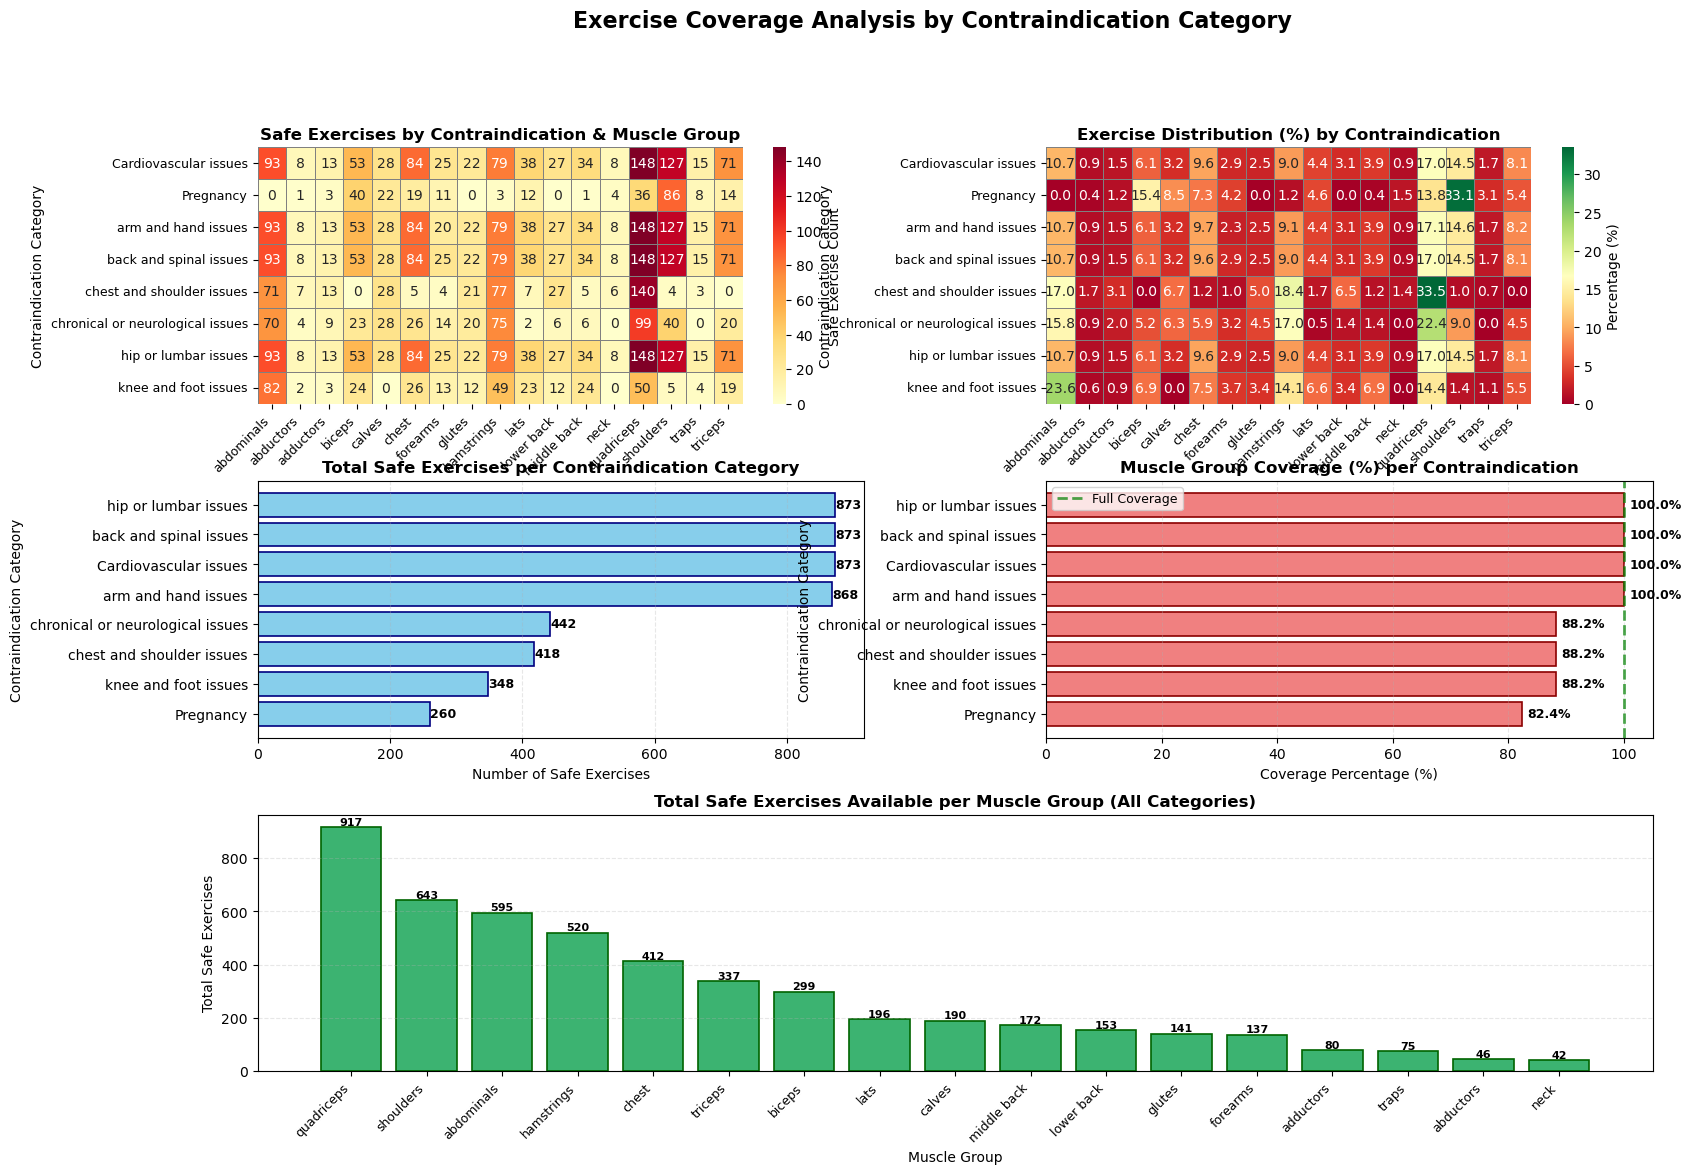


Database connection closed.

Analysis complete!


In [376]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# ==============================================================================
# DATABASE CONNECTION
# ==============================================================================

def connect_db(db_path='exercises.db'):
    """Connect to the SQLite database."""
    return sqlite3.connect(db_path)


# ==============================================================================
# DATA LOADING FUNCTIONS
# ==============================================================================

def load_contraindication_categories(conn):
    """Load all contraindication categories."""
    query = """
    SELECT 
        category_id,
        category_name,
        display_order
    FROM modification_categories
    WHERE category_type = 'contraindication'
    ORDER BY display_order, category_name
    """
    return pd.read_sql_query(query, conn)


def load_all_muscle_groups(conn):
    """Load all unique muscle groups."""
    query = """
    SELECT 
        muscle_id,
        muscle_name
    FROM muscles
    ORDER BY muscle_name
    """
    return pd.read_sql_query(query, conn)


def get_exercises_with_contraindication_category(conn, category_id):
    """Get all exercise IDs that have contraindications in a specific category."""
    query = """
    SELECT DISTINCT ec.exercise_id
    FROM exercise_contraindications ec
    JOIN contraindications c ON ec.contraindication_id = c.contraindication_id
    WHERE c.category_id = ?
    """
    result = pd.read_sql_query(query, conn, params=(category_id,))
    return set(result['exercise_id'].tolist())


def get_safe_exercises_for_category(conn, category_id):
    """
    Get all exercises that are SAFE for people with contraindications in this category.
    (i.e., exercises that DON'T have contraindications in this category)
    """
    unsafe_exercises = get_exercises_with_contraindication_category(conn, category_id)
    
    query = """
    SELECT DISTINCT
        e.id as exercise_id,
        e.name,
        e.level,
        e.equipment,
        e.category
    FROM exercises e
    """
    
    all_exercises = pd.read_sql_query(query, conn)
    
    if unsafe_exercises:
        safe_exercises = all_exercises[~all_exercises['exercise_id'].isin(unsafe_exercises)]
    else:
        safe_exercises = all_exercises
    
    return safe_exercises


def get_muscle_coverage_for_exercises(conn, exercise_ids):
    """Get muscle group coverage (primary muscles) for a list of exercises."""
    if not exercise_ids:
        return pd.DataFrame(columns=['exercise_id', 'muscle_name'])
    
    placeholders = ','.join(['?' for _ in exercise_ids])
    query = f"""
    SELECT 
        epm.exercise_id,
        m.muscle_name
    FROM exercise_primary_muscles epm
    JOIN muscles m ON epm.muscle_id = m.muscle_id
    WHERE epm.exercise_id IN ({placeholders})
    """
    
    return pd.read_sql_query(query, conn, params=exercise_ids)


# ==============================================================================
# ANALYSIS FUNCTIONS
# ==============================================================================

def analyze_coverage_by_contraindication(conn):
    """
    Comprehensive analysis of exercise coverage across muscle groups
    for each contraindication category.
    """
    print("Loading data from database...")
    
    # Load reference data
    contra_categories = load_contraindication_categories(conn)
    all_muscles = load_all_muscle_groups(conn)
    
    print(f"Found {len(contra_categories)} contraindication categories")
    print(f"Found {len(all_muscles)} muscle groups")
    print()
    
    # Build coverage matrix
    coverage_data = []
    coverage_matrix = pd.DataFrame(
        0, 
        index=contra_categories['category_name'].tolist(),
        columns=all_muscles['muscle_name'].tolist()
    )
    
    # Track statistics per category
    category_stats = []
    gaps_data = []
    
    for _, category in contra_categories.iterrows():
        cat_id = category['category_id']
        cat_name = category['category_name']
        
        print(f"Analyzing: {cat_name}...")
        
        # Get safe exercises for this category
        safe_exercises = get_safe_exercises_for_category(conn, cat_id)
        safe_exercise_ids = safe_exercises['exercise_id'].tolist()
        
        # Get muscle coverage for these exercises
        muscle_coverage = get_muscle_coverage_for_exercises(conn, safe_exercise_ids)
        
        # Count exercises per muscle group
        muscle_counts = muscle_coverage.groupby('muscle_name').size().to_dict()
        
        # Fill coverage matrix
        for muscle_name, count in muscle_counts.items():
            if muscle_name in coverage_matrix.columns:
                coverage_matrix.loc[cat_name, muscle_name] = count
        
        # Calculate statistics
        covered_muscles = set(muscle_counts.keys())
        all_muscle_set = set(all_muscles['muscle_name'].tolist())
        missing_muscles = all_muscle_set - covered_muscles
        
        category_stats.append({
            'contraindication_category': cat_name,
            'total_safe_exercises': len(safe_exercises),
            'muscle_groups_covered': len(covered_muscles),
            'total_muscle_groups': len(all_muscle_set),
            'coverage_percentage': (len(covered_muscles) / len(all_muscle_set) * 100) if all_muscle_set else 0
        })
        
        if missing_muscles:
            gaps_data.append({
                'contraindication_category': cat_name,
                'missing_muscle_groups': ', '.join(sorted(missing_muscles)),
                'coverage_ratio': f"{len(covered_muscles)}/{len(all_muscle_set)}"
            })
    
    stats_df = pd.DataFrame(category_stats)
    gaps_df = pd.DataFrame(gaps_data) if gaps_data else None
    
    # Calculate percentage matrix for heatmap
    coverage_pct = coverage_matrix.div(coverage_matrix.sum(axis=1), axis=0) * 100
    coverage_pct = coverage_pct.fillna(0)
    
    return {
        'coverage_matrix': coverage_matrix,
        'coverage_percentage': coverage_pct,
        'category_stats': stats_df,
        'gaps': gaps_df,
        'contra_categories': contra_categories,
        'all_muscles': all_muscles
    }


def get_detailed_contraindication_info(conn, category_name):
    """Get detailed information about exercises and contraindications for a category."""
    query = """
    SELECT 
        mc.category_name as contraindication_category,
        c.contraindication_name,
        c.severity,
        COUNT(DISTINCT ec.exercise_id) as affected_exercises,
        GROUP_CONCAT(e.name, '; ') as example_exercises
    FROM modification_categories mc
    JOIN contraindications c ON mc.category_id = c.category_id
    LEFT JOIN exercise_contraindications ec ON c.contraindication_id = ec.contraindication_id
    LEFT JOIN exercises e ON ec.exercise_id = e.id
    WHERE mc.category_name = ?
    GROUP BY mc.category_name, c.contraindication_name, c.severity
    ORDER BY c.severity DESC, c.contraindication_name
    """
    return pd.read_sql_query(query, conn, params=(category_name,))


# ==============================================================================
# VISUALIZATION FUNCTIONS
# ==============================================================================

def visualize_coverage(results, figsize=(18, 12)):
    """Create comprehensive visualizations for exercise coverage analysis."""
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Heatmap of exercise counts
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(results['coverage_matrix'], annot=True, fmt='d', cmap='YlOrRd', 
                ax=ax1, cbar_kws={'label': 'Safe Exercise Count'}, 
                linewidths=0.5, linecolor='gray')
    ax1.set_title('Safe Exercises by Contraindication & Muscle Group', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Muscle Group', fontsize=10)
    ax1.set_ylabel('Contraindication Category', fontsize=10)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    plt.setp(ax1.get_yticklabels(), rotation=0, fontsize=9)
    
    # 2. Heatmap of coverage percentages
    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(results['coverage_percentage'], annot=True, fmt='.1f', 
                cmap='RdYlGn', ax=ax2, cbar_kws={'label': 'Percentage (%)'}, 
                linewidths=0.5, linecolor='gray')
    ax2.set_title('Exercise Distribution (%) by Contraindication', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Muscle Group', fontsize=10)
    ax2.set_ylabel('Contraindication Category', fontsize=10)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    plt.setp(ax2.get_yticklabels(), rotation=0, fontsize=9)
    
    # 3. Bar chart of total safe exercises per contraindication
    ax3 = fig.add_subplot(gs[1, 0])
    stats_sorted = results['category_stats'].sort_values('total_safe_exercises')
    bars = ax3.barh(stats_sorted['contraindication_category'], 
                     stats_sorted['total_safe_exercises'], 
                     color='skyblue', edgecolor='navy', linewidth=1.2)
    ax3.set_title('Total Safe Exercises per Contraindication Category', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Number of Safe Exercises', fontsize=10)
    ax3.set_ylabel('Contraindication Category', fontsize=10)
    ax3.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar in bars:
        width = bar.get_width()
        ax3.text(width, bar.get_y() + bar.get_height()/2, 
                f'{int(width)}',
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # 4. Coverage percentage bar chart
    ax4 = fig.add_subplot(gs[1, 1])
    bars2 = ax4.barh(stats_sorted['contraindication_category'], 
                      stats_sorted['coverage_percentage'], 
                      color='lightcoral', edgecolor='darkred', linewidth=1.2)
    ax4.set_title('Muscle Group Coverage (%) per Contraindication', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Coverage Percentage (%)', fontsize=10)
    ax4.set_ylabel('Contraindication Category', fontsize=10)
    ax4.axvline(x=100, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Full Coverage')
    ax4.legend(fontsize=9)
    ax4.grid(axis='x', alpha=0.3, linestyle='--')
    ax4.set_xlim(0, 105)
    
    # Add percentage labels on bars
    for bar in bars2:
        width = bar.get_width()
        ax4.text(width + 1, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%',
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # 5. Muscle group coverage summary
    ax5 = fig.add_subplot(gs[2, :])
    muscle_totals = results['coverage_matrix'].sum(axis=0).sort_values(ascending=False)
    bars3 = ax5.bar(range(len(muscle_totals)), muscle_totals.values, 
                     color='mediumseagreen', edgecolor='darkgreen', linewidth=1.2)
    ax5.set_title('Total Safe Exercises Available per Muscle Group (All Categories)', 
                  fontsize=12, fontweight='bold')
    ax5.set_xlabel('Muscle Group', fontsize=10)
    ax5.set_ylabel('Total Safe Exercises', fontsize=10)
    ax5.set_xticks(range(len(muscle_totals)))
    ax5.set_xticklabels(muscle_totals.index, rotation=45, ha='right', fontsize=9)
    ax5.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, bar in enumerate(bars3):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2, height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    fig.suptitle('Exercise Coverage Analysis by Contraindication Category', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    return fig


# ==============================================================================
# REPORTING FUNCTIONS
# ==============================================================================

def generate_coverage_report(conn, results):
    """Generate a detailed text report of coverage analysis."""
    print("="*80)
    print("EXERCISE COVERAGE ANALYSIS REPORT")
    print("Analyzing Safe Exercises for Different Contraindication Categories")
    print("="*80)
    print()
    
    print(f"Total Contraindication Categories: {len(results['contra_categories'])}")
    print(f"Total Muscle Groups: {len(results['all_muscles'])}")
    print()
    
    print("-"*80)
    print("COVERAGE STATISTICS BY CONTRAINDICATION CATEGORY")
    print("-"*80)
    print(results['category_stats'].to_string(index=False))
    print()
    
    if results['gaps'] is not None and not results['gaps'].empty:
        print("-"*80)
        print("⚠️  COVERAGE GAPS IDENTIFIED")
        print("-"*80)
        print("The following contraindication categories lack exercises for some muscle groups:")
        print()
        for idx, row in results['gaps'].iterrows():
            print(f"▸ {row['contraindication_category']}")
            print(f"  Coverage Ratio: {row['coverage_ratio']}")
            print(f"  Missing Muscle Groups: {row['missing_muscle_groups']}")
            print()
    else:
        print("-"*80)
        print("✓ NO COVERAGE GAPS")
        print("-"*80)
        print("All contraindication categories have safe exercises for all muscle groups!")
        print()
    
    print("-"*80)
    print("DETAILED COVERAGE MATRIX (Exercise Count)")
    print("-"*80)
    print(results['coverage_matrix'].to_string())
    print()
    
    print("-"*80)
    print("COVERAGE PERCENTAGE BY MUSCLE GROUP")
    print("-"*80)
    print(results['coverage_percentage'].round(1).to_string())
    print()
    
    # Detailed contraindication breakdown
    print("-"*80)
    print("DETAILED CONTRAINDICATION BREAKDOWN")
    print("-"*80)
    for _, category in results['contra_categories'].iterrows():
        print(f"\n▸ {category['category_name'].upper()}")
        print("-" * 60)
        details = get_detailed_contraindication_info(conn, category['category_name'])
        if not details.empty:
            for _, row in details.iterrows():
                print(f"  • {row['contraindication_name']}")
                print(f"    Severity: {row['severity'] if pd.notna(row['severity']) else 'Not specified'}")
                print(f"    Affected Exercises: {row['affected_exercises']}")
                if pd.notna(row['example_exercises']):
                    examples = row['example_exercises'].split('; ')[:3]
                    print(f"    Examples: {', '.join(examples)}...")
                print()


def export_results_to_excel(results, filename='exercise_coverage_analysis.xlsx'):
    """Export all results to an Excel file with multiple sheets."""
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # Coverage matrix
        results['coverage_matrix'].to_excel(writer, sheet_name='Coverage Matrix')
        
        # Coverage percentages
        results['coverage_percentage'].round(2).to_excel(writer, sheet_name='Coverage Percentage')
        
        # Statistics
        results['category_stats'].to_excel(writer, sheet_name='Statistics', index=False)
        
        # Gaps (if any)
        if results['gaps'] is not None:
            results['gaps'].to_excel(writer, sheet_name='Coverage Gaps', index=False)
        
        # Summary by muscle group
        muscle_summary = results['coverage_matrix'].sum(axis=0).to_frame('Total Safe Exercises')
        muscle_summary.index.name = 'Muscle Group'
        muscle_summary.to_excel(writer, sheet_name='Muscle Group Summary')
    
    print(f"\n✓ Full report exported to '{filename}'")


# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

def main(db_path='exercises.db'):
    """Main execution function."""
    print("Exercise Coverage Analysis Tool")
    print("="*80)
    print()
    
    # Connect to database
    print(f"Connecting to database: {db_path}")
    conn = connect_db(db_path)
    
    try:
        # Run analysis
        print("\nRunning coverage analysis...")
        print()
        results = analyze_coverage_by_contraindication(conn)
        
        print("\n" + "="*80)
        # Generate report
        generate_coverage_report(conn, results)
        
        # Create visualizations
        print("="*80)
        print("Generating visualizations...")
        fig = visualize_coverage(results)
        
        output_file = 'exercise_coverage_analysis.png'
        plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Visualization saved as '{output_file}'")
        
        # Export to Excel
        #export_results_to_excel(results)
        
        # Show plot
        plt.show()
        
    finally:
        conn.close()
        print("\nDatabase connection closed.")
    
    print("\n" + "="*80)
    print("Analysis complete!")
    print("="*80)


if __name__ == "__main__":
    # Run the analysis
    # Modify the path if your database is in a different location
    main(db_path='exercises.db')
    

In [374]:
enr_file[0]

{'name': '3/4 Sit-Up',
 'force': 'pull',
 'level': 'beginner',
 'mechanic': 'compound',
 'equipment': 'body only',
 'primaryMuscles': ['abdominals'],
 'secondaryMuscles': ['hip flexors', 'obliques'],
 'instructions': ['Lie down on the floor and secure your feet. Your legs should be bent at the knees.',
  'Place your hands behind or to the side of your head. You will begin with your back on the ground. This will be your starting position.',
  'Flex your hips and spine to raise your torso toward your knees.',
  'At the top of the contraction your torso should be perpendicular to the ground. Reverse the motion, going only ¾ of the way down.',
  'Repeat for the recommended amount of repetitions.'],
 'category': 'strength',
 'images': ['3_4_Sit-Up/0.jpg', '3_4_Sit-Up/1.jpg'],
 'id': '3_4_Sit-Up',
 'contraindications': ['herniated disc',
  'spinal stenosis',
  'spondylolisthesis',
  'sciatica',
  'osteoporosis',
  'recent abdominal surgery',
  'pregnancy'],
 'contraindicationDetails': {'hern